In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# load data
df = pd.read_csv("PJME_hourly.csv")

In [4]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [8]:
df.columns

Index(['PJME_MW'], dtype='object')

In [5]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
# set date as index

df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index('Datetime',inplace=True)

In [7]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


### Data Cleaning & EDA

<Axes: xlabel='Datetime'>

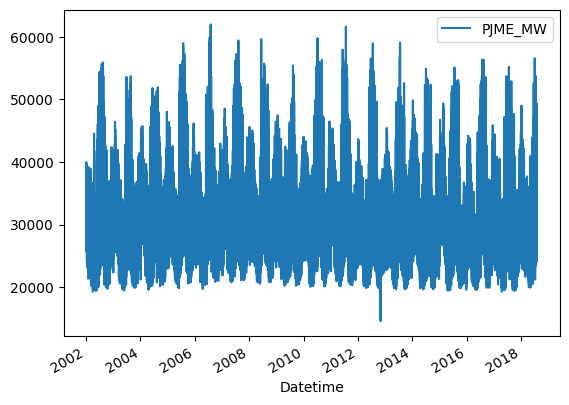

In [11]:
df.plot()

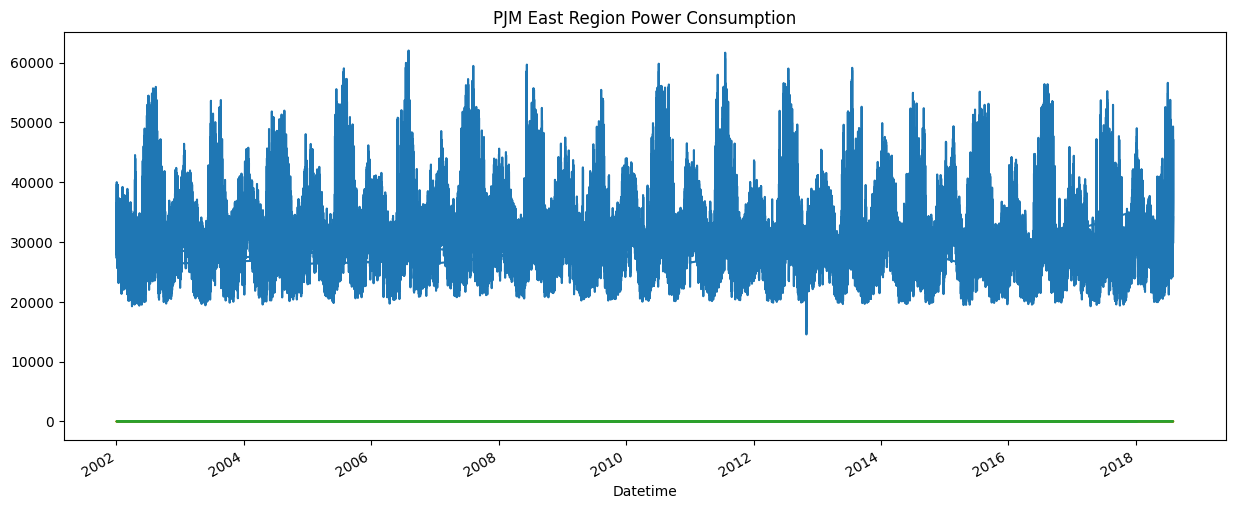

In [16]:
# Full Dataset Line Plot
df.plot(figsize=(15, 6), title="PJM East Region Power Consumption", legend=False)
plt.show()


C:\Users\heetb\AppData\Local\Temp\ipykernel_21704\2993622950.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()
C:\Users\heetb\AppData\Local\Temp\ipykernel_21704\2993622950.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').mean()


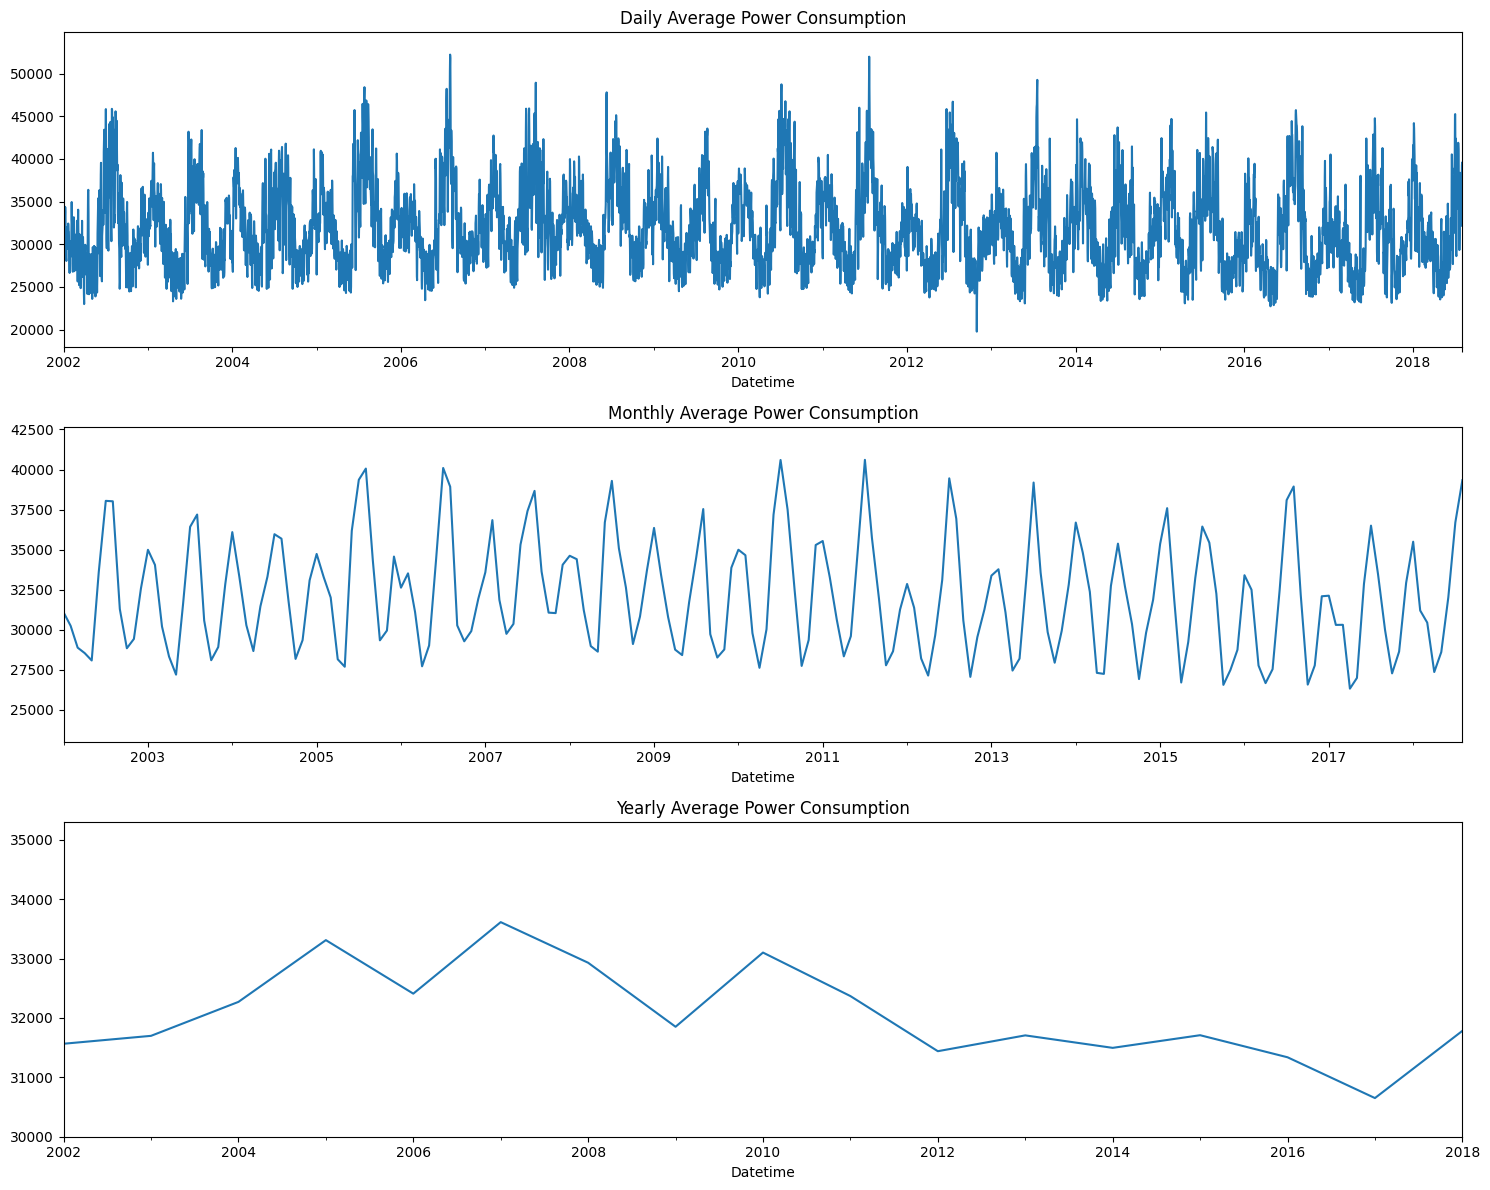

In [19]:
# Aggregated Views
df_daily = df.resample('D').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

fig, axes = plt.subplots(3, 1, figsize=(15, 12))
df_daily.plot(ax=axes[0], title="Daily Average Power Consumption", legend=False)
axes[0].set_ylim(18000)
df_monthly.plot(ax=axes[1], title="Monthly Average Power Consumption", legend=False)
axes[1].set_ylim(23000)
df_yearly.plot(ax=axes[2], title="Yearly Average Power Consumption", legend=False)
axes[2].set_ylim(30000)
plt.tight_layout()
plt.show()


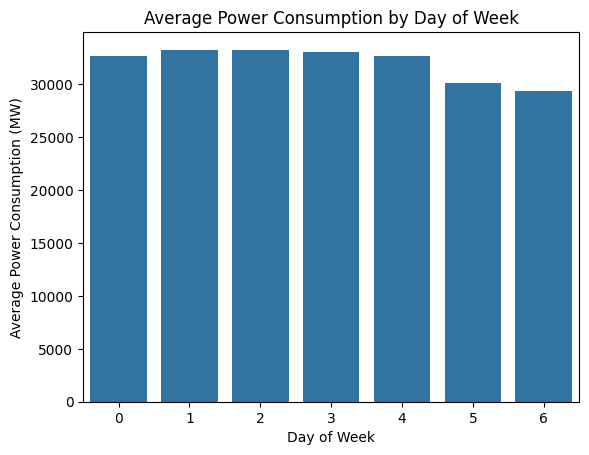

In [25]:
df['dayofweek'] = df.index.dayofweek
weekly_avg = df.groupby('dayofweek')['PJME_MW'].mean()

sns.barplot(x=weekly_avg.index, y=weekly_avg.values)  
plt.title("Average Power Consumption by Day of Week")
plt.xlabel("Day of Week")  
plt.ylabel("Average Power Consumption (MW)") 
plt.show()

In [27]:
# check for stationarity

from statsmodels.tsa.stattools import adfuller

# ADF Test
adf_test = adfuller(df['PJME_MW'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: -18.828912729084074
p-value: 2.022124508152674e-30
Critical Values: {'1%': -3.430395009088914, '5%': -2.861559893380481, '10%': -2.5667805885384065}
The data is stationary.


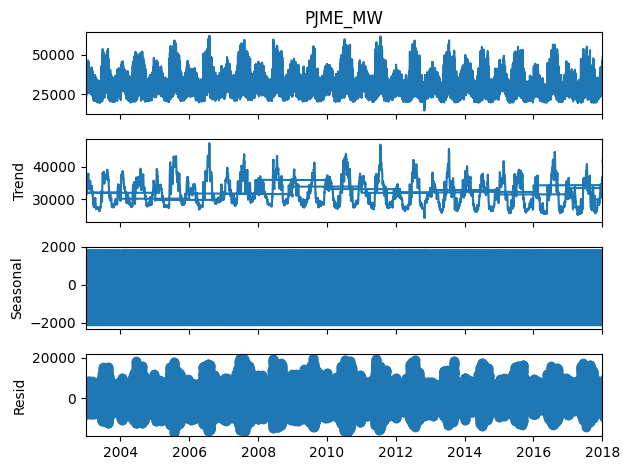

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['PJME_MW'], model='additive', period=24*7)
decomposition.plot()
plt.show()


There is obviously seasonality. As a result, we will sarima model to get better result.

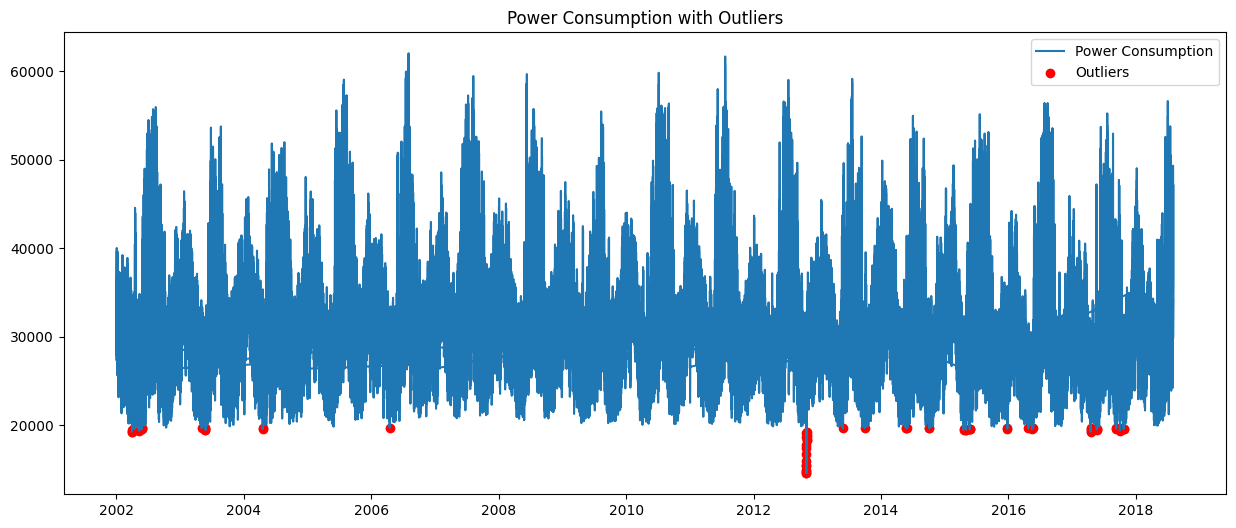

In [35]:
# detect anamolies exist or not.
outliers = df[(df['PJME_MW'] < df['PJME_MW'].quantile(0.0005))]

plt.figure(figsize=(15, 6))
plt.plot(df['PJME_MW'], label="Power Consumption")
plt.scatter(outliers.index, outliers['PJME_MW'], color='red', label='Outliers')
plt.legend()
plt.title("Power Consumption with Outliers")
plt.show()


In [37]:
# Remove outliers.

threshold = df['PJME_MW'].quantile(0.0005)
df_cleaned = df[df['PJME_MW'] >= threshold]

print(f"Original data size: {len(df)}")
print(f"Cleaned data size: {len(df_cleaned)}")

Original data size: 145366
Cleaned data size: 145294


In [40]:
# check for null values.
df_cleaned.isna().sum()

PJME_MW      0
hour         0
dayofweek    0
dtype: int64

In [39]:
def create_time_features(df):
    """
    Generate time-based features from the index.
    """
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    
    return df

# # Apply the function
# df_cleaned = create_time_features(df_cleaned)

# # Preview the updated DataFrame 
# print(df_cleaned.head())


,PJME_MW,hour,dayofweek
Datetime,,,
2002-12-31 01:00:00,26498.0,1,1
2002-12-31 02:00:00,25147.0,2,1
2002-12-31 03:00:00,24574.0,3,1
2002-12-31 04:00:00,24393.0,4,1
2002-12-31 05:00:00,24860.0,5,1


In [41]:
def add_lag_features(df, target, num_lags):
    """
    Add lagged features for the target variable.
    
    Parameters:
    - df: DataFrame
    - target: Name of the target column
    - num_lags: Number of lags to create
    """
    for lag in range(1, num_lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    return df


#### Split data into train and test

Training data size: 101705
Testing data size: 43589


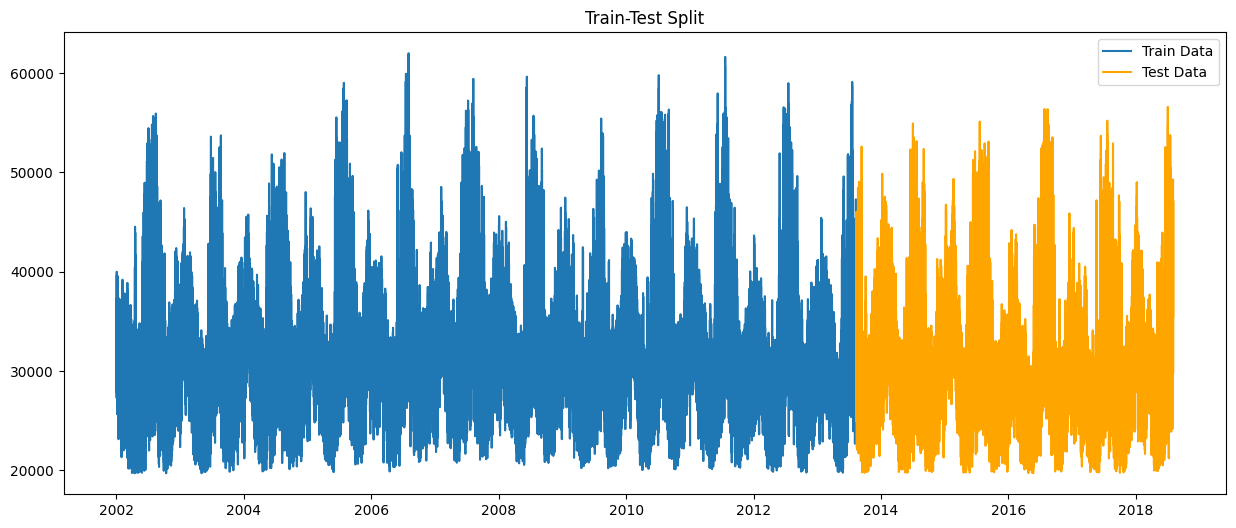

In [49]:
df_cleaned = df_cleaned.sort_index()

split_idx = int(len(df_cleaned) * 0.7)


train_data = df_cleaned[:split_idx]
test_data = df_cleaned[split_idx:]

# Print sizes of each dataset
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

#Plot the train-test split for visualization

plt.figure(figsize=(15, 6))
plt.plot(train_data['PJME_MW'], label="Train Data")
plt.plot(test_data['PJME_MW'], label="Test Data", color='orange')
plt.legend()
plt.title("Train-Test Split")
plt.show()